In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

### Problem
The goal of this problem is to train a neural network to categorize pictures of flowers into 1 of 5 categories: Daisies, Dandelions, Roses, Sunflowers, and Tulips.

This will be using a dataset of flower images taken from Kaggle: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset/data

### EDA
Starting by importing the photos. The photos come in 5 folders (for each flower type), so I want to add them to the dataframe with the filename in one column, and the label (folder name) in the 2nd column. There are 3670 photos in total.

In [2]:
image_dir = ["flower_photos"]

data = []

for flower_dir in image_dir:

        for subdir, _, files in os.walk(flower_dir):
            label = os.path.basename(subdir)  
            for file in files:
                file_path = os.path.join(subdir, file)
                data.append([file_path, label])
                
label_df = pd.DataFrame(data, columns=['file', 'label'])

print(label_df.info())
print(label_df.columns)
label_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    3670 non-null   object
 1   label   3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None
Index(['file', 'label'], dtype='object')


,file,label
0,flower_photos/roses/16209331331_343c899d38.jpg,roses
1,flower_photos/roses/5777669976_a205f61e5b.jpg,roses
2,flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg,roses
3,flower_photos/roses/15011625580_7974c44bce.jpg,roses
4,flower_photos/roses/17953368844_be3d18cf30_m.jpg,roses


Since I'm making the dataframe myself, I don't really need to worry about checking for incorrect/null data. I do want to check the distribution of pictures to make sure it's relatively even. Looking at the graph, there's a bit of a gap between the number of dandelions and the others, but overall it's relatively even.

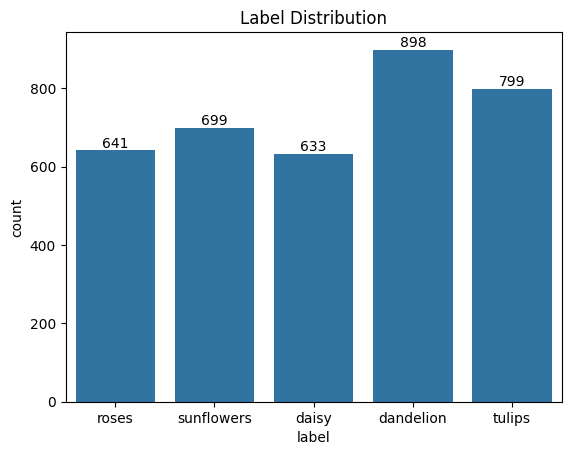

In [5]:
# Label Distribution
ax = sns.countplot(x='label', data=label_df)
ax.bar_label(ax.containers[0])
plt.title('Label Distribution')
plt.show()

### Building the Models

In [ ]:
# placeholder

### Compiling Models

In [ ]:
# placeholder

### Hyperparameter Tuning

In [ ]:
# placeholder

### Analysis + Conclusion

In [1]:
# placeholder